In [28]:
import pandas as pd
# Loading the datasets
training_data = pd.read_csv("loan_data_training.csv")
unknown_data = pd.read_csv("loan_data_unknown.csv")


# Displaying the first few rows of the training and unknown datasets
training_data_head = training_data.head()
unknown_data_head = unknown_data.head()

training_data_head, unknown_data_head


(   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
 0      100002       1         Cash loans           M            N   
 1      100031       1         Cash loans           F            N   
 2      100047       1         Cash loans           M            N   
 3      100049       1         Cash loans           F            N   
 4      100112       1         Cash loans           M            Y   
 
   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
 0               Y             0          202500.0    406597.5      24700.5   
 1               Y             0          112500.0    979992.0      27076.5   
 2               Y             0          202500.0   1193580.0      35028.0   
 3               N             0          135000.0    288873.0      16258.5   
 4               Y             0          315000.0    953460.0      64107.0   
 
    ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
 0  ...               

In [29]:
ntrain = training_data.shape[0]
ntest = unknown_data.shape[0]
df = pd.concat((training_data, unknown_data))

In [30]:
ntrain

42452

In [31]:
ntest

4716

In [32]:
train = df[:ntrain]
train['TARGET'].isnull().sum()

0

# 2. Data Preprocessing and Transformations:
### 1) missing values
### 2) Basic feature engineering (related to dimension reduction)
        - Binning
        - Normalisation (Data scaling, amount value)
        - Discretisation (for age)
### 3) Advanced feature engineering
        - Domain-Specific Features
        - Interaction Features
### 4) Outlier Handling

In [33]:
# Check the number of missing values in each column, excluding the 'TARGET' column
missing_values = df.drop(columns=['TARGET']).isnull().sum()

# Display columns with missing values and their counts
missing_values[missing_values > 0].sort_values(ascending=False)


EXT_SOURCE_3                  9988
AMT_REQ_CREDIT_BUREAU_HOUR    7158
AMT_REQ_CREDIT_BUREAU_DAY     7158
AMT_REQ_CREDIT_BUREAU_WEEK    7158
AMT_REQ_CREDIT_BUREAU_MON     7158
AMT_REQ_CREDIT_BUREAU_QRT     7158
AMT_REQ_CREDIT_BUREAU_YEAR    7158
NAME_TYPE_SUITE                178
OBS_30_CNT_SOCIAL_CIRCLE       118
DEF_30_CNT_SOCIAL_CIRCLE       118
OBS_60_CNT_SOCIAL_CIRCLE       118
DEF_60_CNT_SOCIAL_CIRCLE       118
EXT_SOURCE_2                   103
AMT_GOODS_PRICE                 54
AMT_ANNUITY                      1
CNT_FAM_MEMBERS                  1
dtype: int64

In [34]:
train = df[:ntrain]
train['TARGET'].isnull().sum()

0

In [35]:
# Handling missing values

# For EXT_SOURCE_3, use the median value
df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].median(), inplace=True)
df['DAYS_EMPLOYED'].fillna(df['DAYS_EMPLOYED'].median(), inplace=True)
df['DAYS_ID_PUBLISH'].fillna(df['DAYS_EMPLOYED'].median(), inplace=True)

# For AMT_REQ_CREDIT_BUREAU_* columns, replace missing values with 0
credit_bureau_cols = [col for col in df.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
df[credit_bureau_cols] = df[credit_bureau_cols].fillna(0)

# For NAME_TYPE_SUITE, replace with 'Unknown'
df['NAME_TYPE_SUITE'].fillna('Unknown', inplace=True)

# For other numerical columns, use the median value
other_cols_with_missing = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
                           'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
                           'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS']
for col in other_cols_with_missing:
    df[col].fillna(df[col].median(), inplace=True)

# Check if there are still any missing values left
remaining_missing = df.drop(columns=['TARGET']).isnull().sum()
remaining_missing


SK_ID_CURR                    0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 71, dtype: int64

In [36]:
train = df[:ntrain]
train['TARGET'].isnull().sum()

0

In [37]:
df['DAYS_EMPLOYED'].isnull().sum()

0

In [38]:
# # Identify categorical columns
# categorical_cols = training_data.select_dtypes(include=['object']).columns.tolist()

# # One-hot encode categorical columns
# training_data_encoded = pd.get_dummies(training_data, columns=categorical_cols)

# # Display the shape of the new dataset and the first few rows
# training_data_encoded.shape, training_data_encoded.head()


# About dimension reduction

## 1. Binning Techniques

The occurrence of null values after binning usually happens when there are values in the columns that fall outside the specified bin ranges. To avoid this, you can adjust the bin ranges to ensure they encompass all values in the columns.

In [39]:
df['DAYS_ID_PUBLISH'].unique()

array([-2120, -1827, -1029, ..., -6157, -5738, -5317])

In [40]:
# For Equi-width
bins_employed_width = [-16000, -12000, -8000, -4000, -2000, 0, 400000] # Notice the large last bin for the placeholder
df['DAYS_EMPLOYED'] = pd.cut(df['DAYS_EMPLOYED'], bins=bins_employed_width)

# For Equi-width
bins_publish_width = [-6100, -4800, -3600, -2400, -1200, 0]
df['DAYS_ID_PUBLISH'] = pd.cut(df['DAYS_ID_PUBLISH'], bins=bins_publish_width)

df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].cat.add_categories([0]).fillna(0)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].cat.add_categories([0]).fillna(0)

# Now apply your mapping
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].cat.codes
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].cat.codes


In [41]:
train = df[:ntrain]
train['TARGET'].isnull().sum()

0

In [42]:


# Now apply your mapping
df.loc[df['DAYS_ID_PUBLISH'].between(-6100, -4800), 'DAYS_ID_PUBLISH'] = 4
df.loc[df['DAYS_ID_PUBLISH'].between(-4800, -3600), 'DAYS_ID_PUBLISH'] = 3
df.loc[df['DAYS_ID_PUBLISH'].between(-3600, -2400), 'DAYS_ID_PUBLISH'] = 2
df.loc[df['DAYS_ID_PUBLISH'].between(-2400, -1200), 'DAYS_ID_PUBLISH'] = 1
df.loc[df['DAYS_ID_PUBLISH'].between(-1200, 0), 'DAYS_ID_PUBLISH'] = 0

df.loc[df['DAYS_EMPLOYED'].between(-16000, -12000), 'DAYS_EMPLOYED'] = 5
df.loc[df['DAYS_EMPLOYED'].between(-12000, -8000), 'DAYS_EMPLOYED'] = 4
df.loc[df['DAYS_EMPLOYED'].between(-8000, -4000), 'DAYS_EMPLOYED'] = 3
df.loc[df['DAYS_EMPLOYED'].between(-4000, -2000), 'DAYS_EMPLOYED'] = 2
df.loc[df['DAYS_EMPLOYED'].between(-2000, 0), 'DAYS_EMPLOYED'] = 1
df.loc[df['DAYS_EMPLOYED'].between(0, 400000), 'DAYS_EMPLOYED'] = 0


In [43]:
train = df[:ntrain]
train['TARGET'].isnull().sum()

0

## 2. Normalization Techniques with AMT Values

In [44]:
# a) Min-max Normalization
# Transforms the values onto the range [0.0-1.0].

df['AMT_INCOME_TOTAL'] = (df['AMT_INCOME_TOTAL'] - df['AMT_INCOME_TOTAL'].min()) / (df['AMT_INCOME_TOTAL'].max() - df['AMT_INCOME_TOTAL'].min())
df['AMT_CREDIT'] = (df['AMT_CREDIT'] - df['AMT_CREDIT'].min()) / (df['AMT_CREDIT'].max() - df['AMT_CREDIT'].min())
df['AMT_ANNUITY'] = (df['AMT_ANNUITY'] - df['AMT_ANNUITY'].min()) / (df['AMT_ANNUITY'].max() - df['AMT_ANNUITY'].min())
df['AMT_GOODS_PRICE'] = (df['AMT_GOODS_PRICE'] - df['AMT_GOODS_PRICE'].min()) / (df['AMT_GOODS_PRICE'].max() - df['AMT_GOODS_PRICE'].min())
df['DAYS_REGISTRATION'] = (df['DAYS_REGISTRATION'] - df['DAYS_REGISTRATION'].min()) / (df['DAYS_REGISTRATION'].max() - df['DAYS_REGISTRATION'].min())


## 3. Discretization with DAYS_BIRTH

In [45]:
bins = [-30000, -20000, -10000, 0]
labels = ['Elderlies', 'Adults', 'Children and Young adults']
df['DAYS_BIRTH'] = pd.cut(df['DAYS_BIRTH'], bins=bins, labels=labels, right=True)


In [46]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].astype('object')

In [47]:
df.loc[df['DAYS_BIRTH'] == 'Children and Young adults', 'DAYS_BIRTH'] = 0
df.loc[df['DAYS_BIRTH'] == 'Adults', 'DAYS_BIRTH'] = 1
df.loc[df['DAYS_BIRTH'] == 'Elderlies', 'DAYS_BIRTH'] = 2

In [48]:
df['DAYS_BIRTH']

0       0
1       1
2       1
3       1
4       1
       ..
4711    1
4712    1
4713    0
4714    2
4715    1
Name: DAYS_BIRTH, Length: 47168, dtype: object

## Advanced Feature Engineering

In [21]:
# 1. Domain-Specific Features

# Debt-to-Income Ratio
df['DEBT_TO_INCOME'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

# Annuity-to-Income Ratio
df['ANNUITY_TO_INCOME'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# Credit Term
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# 2. Interaction Features

# Interaction between AMT_INCOME_TOTAL, AMT_CREDIT, and AMT_ANNUITY
df['INCOME_x_CREDIT'] = df['AMT_INCOME_TOTAL'] * df['AMT_CREDIT']
df['INCOME_x_ANNUITY'] = df['AMT_INCOME_TOTAL'] * df['AMT_ANNUITY']
df['CREDIT_x_ANNUITY'] = df['AMT_CREDIT'] * df['AMT_ANNUITY']

# Interaction between DAYS_EMPLOYED and DAYS_BIRTH
df['EMPLOYED_x_BIRTH'] = df['DAYS_EMPLOYED'] * df['DAYS_BIRTH']

# Display the first few rows with the new features
df[['DEBT_TO_INCOME', 'ANNUITY_TO_INCOME', 'CREDIT_TERM', 'INCOME_x_CREDIT', 'INCOME_x_ANNUITY', 'CREDIT_x_ANNUITY', 'EMPLOYED_x_BIRTH']].head()


,DEBT_TO_INCOME,ANNUITY_TO_INCOME,CREDIT_TERM,INCOME_x_CREDIT,INCOME_x_ANNUITY,CREDIT_x_ANNUITY,EMPLOYED_x_BIRTH
0,60.053121,66.868579,1.113490,0.000137,0.000153,0.009179,0
1,316.193763,150.523964,0.476050,0.000174,0.000083,0.026237,0
2,190.753016,97.524470,0.511260,0.000436,0.000223,0.042522,0
3,65.502845,67.617929,1.032290,0.000057,0.000059,0.003871,0
4,92.214146,112.363676,1.218508,0.000564,0.000688,0.063400,0


In [22]:
train = df[:ntrain]
train['TARGET'].isnull().sum()

0

In [49]:
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Detecting outliers for continuous columns, excluding the 'TARGET' column
continuous_columns = df.select_dtypes(include=[float, int]).columns.difference(['SK_ID_CURR','TARGET'])

outliers_data = {}
for column in continuous_columns:
    outliers_data[column] = len(detect_outliers(df, column))

outliers_data


{'AMT_ANNUITY': 1018,
 'AMT_CREDIT': 1191,
 'AMT_GOODS_PRICE': 1832,
 'AMT_INCOME_TOTAL': 1901,
 'AMT_REQ_CREDIT_BUREAU_DAY': 238,
 'AMT_REQ_CREDIT_BUREAU_HOUR': 253,
 'AMT_REQ_CREDIT_BUREAU_MON': 6502,
 'AMT_REQ_CREDIT_BUREAU_QRT': 7370,
 'AMT_REQ_CREDIT_BUREAU_WEEK': 1321,
 'AMT_REQ_CREDIT_BUREAU_YEAR': 544,
 'CNT_CHILDREN': 699,
 'CNT_FAM_MEMBERS': 655,
 'DAYS_LAST_PHONE_CHANGE': 109,
 'DAYS_REGISTRATION': 153,
 'DEF_30_CNT_SOCIAL_CIRCLE': 6132,
 'DEF_60_CNT_SOCIAL_CIRCLE': 4578,
 'EXT_SOURCE_2': 0,
 'EXT_SOURCE_3': 0,
 'FLAG_CONT_MOBILE': 90,
 'FLAG_DOCUMENT_10': 1,
 'FLAG_DOCUMENT_11': 160,
 'FLAG_DOCUMENT_12': 0,
 'FLAG_DOCUMENT_13': 113,
 'FLAG_DOCUMENT_14': 106,
 'FLAG_DOCUMENT_15': 36,
 'FLAG_DOCUMENT_16': 394,
 'FLAG_DOCUMENT_17': 5,
 'FLAG_DOCUMENT_18': 328,
 'FLAG_DOCUMENT_19': 32,
 'FLAG_DOCUMENT_2': 4,
 'FLAG_DOCUMENT_20': 19,
 'FLAG_DOCUMENT_21': 21,
 'FLAG_DOCUMENT_3': 0,
 'FLAG_DOCUMENT_4': 3,
 'FLAG_DOCUMENT_5': 723,
 'FLAG_DOCUMENT_6': 3669,
 'FLAG_DOCUMENT_7': 8,
 '

In [50]:
import numpy as np

def replace_outliers_with_median(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    median_value = data[column].median()
    
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median_value, data[column])
    return data

for column in continuous_columns:
    df = replace_outliers_with_median(df, column)


In [83]:
# def remove_outliers(data, column):
#     Q1 = data[column].quantile(0.25)
#     Q3 = data[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# for column in continuous_columns:
#     df = remove_outliers(df, column)


In [25]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Display the shape of the new dataset and the first few rows
df_encoded.shape, df_encoded.head()


/var/folders/r1/xx87h9z55rxc26_ykt_2rjcm0000gn/T/ipykernel_15762/4265721041.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_encoded = pd.get_dummies(df, columns=categorical_cols)
/var/folders/r1/xx87h9z55rxc26_ykt_2rjcm0000gn/T/ipykernel_15762/4265721041.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_encoded = pd.get_dummies(df, columns=categorical_cols)


((47168, 175),
    SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
 0      100002     1.0           0.0          0.001512    0.090793   
 1      100031     1.0           0.0          0.000742    0.234765   
 2      100047     1.0           0.0          0.001512    0.288394   
 3      100049     1.0           0.0          0.000935    0.061233   
 4      100112     1.0           0.0          0.002474    0.228103   
 
    AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  \
 0     0.101097         0.086076                    0.018801              0   
 1     0.111760         0.184810                    0.018029              0   
 2     0.147444         0.227848                    0.025164              0   
 3     0.063211         0.054430                    0.007305              0   
 4     0.102793         0.240506                    0.030755              0   
 
    DAYS_REGISTRATION  ...  ORGANIZATION_TYPE_Trade: type 5  \
 0           0.840893  .

In [51]:
df_label = df_encoded.copy()
df_onehot = df_encoded.copy()
ntrain = 42452
train = df_onehot[:ntrain]
test = df_onehot[ntrain:].drop('TARGET', axis=1)
y_train = df_onehot[['TARGET']].copy()

In [199]:
drop_features = ['SK_ID_CURR', 'TARGET']
df_onehot = df_encoded.drop(drop_features, axis=1).copy()
df_onehot.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMPLOYED_x_BIRTH_0
0,0.0,0.001512,0.090793,0.101097,0.086076,0.018801,0,0.840893,3,1.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,0.000742,0.234765,0.111760,0.184810,0.018029,0,0.713320,3,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,0.001512,0.288394,0.147444,0.227848,0.025164,0,0.948447,4,1.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,0.000935,0.061233,0.063211,0.054430,0.007305,0,0.998037,1,1.0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,0.002474,0.228103,0.102793,0.240506,0.030755,0,0.790562,4,1.0,...,0,0,0,0,0,0,0,0,0,1


### When I load later, Just start from this part!

In [2]:
import pickle
import pandas as pd

with open('ass3_final_train_sample.pickle', 'rb') as pickle_filename:
    train = pickle.load(pickle_filename)


In [3]:
from sklearn.model_selection import train_test_split

X = train.drop('TARGET', axis=1)
y = train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=777)


In [225]:
y

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
42447    0.0
42448    0.0
42449    0.0
42450    0.0
42451    0.0
Name: TARGET, Length: 42452, dtype: float64

# different models & accuracy

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the classifiers
logistic_clf = LogisticRegression(max_iter=1000, random_state=777)
random_forest_clf = RandomForestClassifier()
gradient_boosting_clf = GradientBoostingClassifier()


# Train the classifiers
logistic_clf.fit(X_train, y_train)
random_forest_clf.fit(X_train, y_train)
gradient_boosting_clf.fit(X_train, y_train)

# Predict the probabilities on the validation set
logistic_probs = logistic_clf.predict_proba(X_val)[:, 1]
random_forest_probs = random_forest_clf.predict_proba(X_val)[:, 1]
gradient_boosting_probs = gradient_boosting_clf.predict_proba(X_val)[:, 1]

# Calculate AUC-ROC scores
logistic_auc = roc_auc_score(y_val, logistic_probs)
random_forest_auc = roc_auc_score(y_val, random_forest_probs)
gradient_boosting_auc = roc_auc_score(y_val, gradient_boosting_probs)

logistic_auc, random_forest_auc, gradient_boosting_auc


(0.5699068881061924, 0.7358001073325691, 0.7502218333356246)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

# 1. Decision Tree
decision_tree_clf = DecisionTreeClassifier(random_state=777)
decision_tree_clf.fit(X_train, y_train)
decision_tree_probs = decision_tree_clf.predict_proba(X_val)[:, 1]
decision_tree_auc = roc_auc_score(y_val, decision_tree_probs)

# 2. K-Nearest Neighbors
knn_clf = KNeighborsClassifier(n_neighbors=13)
knn_clf.fit(X_train, y_train)
knn_probs = knn_clf.predict_proba(X_val)[:, 1]
knn_auc = roc_auc_score(y_val, knn_probs)

# 3. Support Vector Machine (Note: SVM might be slower for larger datasets)
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
svm_probs = svm_clf.predict_proba(X_val)[:, 1]
svm_auc = roc_auc_score(y_val, svm_probs)

# 4. Neural Networks
neural_net_clf = MLPClassifier(random_state=42, max_iter=1000)
neural_net_clf.fit(X_train, y_train)
neural_net_probs = neural_net_clf.predict_proba(X_val)[:, 1]
neural_net_auc = roc_auc_score(y_val, neural_net_probs)

# 5. Extra Trees
extra_trees_clf = ExtraTreesClassifier(random_state=42)
extra_trees_clf.fit(X_train, y_train)
extra_trees_probs = extra_trees_clf.predict_proba(X_val)[:, 1]
extra_trees_auc = roc_auc_score(y_val, extra_trees_probs)

# Displaying the AUC-ROC scores for each model
(decision_tree_auc, knn_auc, svm_auc, neural_net_auc, extra_trees_auc)


(0.580901750840279,
 0.5301687649366296,
 0.5127523198107022,
 0.542384174637567,
 0.7219702583350139)

In [26]:
# # 1. Logistic Regression Tuning
# logistic_params = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear']  # 'liblinear' supports both L1 and L2 regularization
# }

# logistic_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
#                                logistic_params, 
#                                scoring='roc_auc', 
#                                cv=5, 
#                                n_jobs=-1)

# logistic_search.fit(X_train, y_train)
# logistic_best_params = logistic_search.best_params_
# logistic_best_score = logistic_search.best_score_

# # 2. Random Forest Tuning
# rf_params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf_search = GridSearchCV(RandomForestClassifier(random_state=42), 
#                          rf_params, 
#                          scoring='roc_auc', 
#                          cv=5, 
#                          n_jobs=-1)

# rf_search.fit(X_train, y_train)
# rf_best_params = rf_search.best_params_
# rf_best_score = rf_search.best_score_

n_estimators : [ default=100 ] 반복 수행하려는 트리 개수를 지정. 크게 지정할수록 예측 성능이 높아질 수 있으나, 너무 크게 지정하면 overfitting을 유발한다.


Difference:

AUC-ROC is a threshold-independent metric that measures the model's ability to distinguish between positive and negative classes over various thresholds.
Accuracy is threshold-dependent and simply measures the proportion of correct predictions out of all predictions.
While both metrics provide valuable insights, their utility might vary depending on the nature of the problem and the dataset. In cases with imbalanced datasets, the AUC-ROC score is generally preferred over accuracy.

고객별로 타겟인지 아닌지 예측하는 문제의 경우, AUC-ROC와 정확도(Accuracy) 중 어떤 지표가 더 적합한지 결정하기 위해서는 데이터의 특성과 비즈니스 목표를 고려해야 합니다.

데이터의 클래스 불균형:

데이터셋에서 타겟인 고객과 아닌 고객의 수가 크게 차이나는지 확인하세요. 만약 타겟인 고객의 수가 전체 고객 중 아주 작다면, 정확도만으로는 모델의 성능을 올바르게 평가하기 어려울 수 있습니다. 이런 경우, AUC-ROC가 더 적합한 지표가 될 수 있습니다.
비즈니스 목표:

예를 들어, 타겟 고객을 정확하게 식별하는 것이 중요한 경우 (즉, False Positive와 False Negative 중 어느 것이 더 피해를 줄 수 있는지에 따라) AUC-ROC, Precision, Recall과 같은 지표를 사용하는 것이 더 적합할 수 있습니다.
반면, 각 클래스를 동등하게 처리해야 하는 경우 정확도가 더 유용할 수 있습니다.
여러 지표의 결합:

한 가지 지표만을 사용하기보다는 여러 지표를 함께 고려하는 것이 종종 더 유용합니다. AUC-ROC, 정확도, Precision, Recall 등 여러 지표를 확인하면 모델의 전체적인 성능을 더 잘 파악할 수 있습니다.
결론적으로, 데이터의 특성과 비즈니스 목표에 따라 적합한 평가 지표를 선택해야 합니다. 클래스 불균형이 있다면 AUC-ROC가 더 적합할 수 있으며, 그렇지 않은 경우 정확도도 유용한 지표가 될 수 있습니다.

우리의 데이터셋 분석
'TARGET' 변수의 분포는 다음과 같습니다:

0 (타겟 아님): 약 52.6%
1 (타겟): 약 47.4%
이 분포는 상대적으로 균형을 이루고 있습니다. 그러나 클래스 간의 불균형이 완전히 없는 것은 아닙니다.

두 클래스 간의 불균형이 크지 않기 때문에 정확도(Accuracy)만 사용하여 모델을 평가하는 것은 문제가 되지 않을 수 있습니다. 그러나 AUC-ROC는 모델의 성능을 평가하는 데 있어 더 탄탄한 지표로 간주되며, 여러 임계값에서 모델의 성능을 종합적으로 평가할 수 있습니다. 따라서 AUC-ROC를 사용하는 것이 더 적합할 수 있습니다.

결론적으로, AUC-ROC를 주요 평가 지표로 사용하면서, 부가적으로 정확도도 함께 확인하는 것이 좋습니다.​

In [240]:
from sklearn.model_selection import GridSearchCV


# 3. Gradient Boosting Tuning
gb_params = {
    'n_estimators': [250,300,350],
    'learning_rate': [0.1,0.2,0.3],
    'max_depth': [3, 4, 6],
    'min_samples_split': [10,11,12]
}

gb_search = GridSearchCV(GradientBoostingClassifier(random_state=777), 
                         gb_params, 
                         scoring='roc_auc', 
                         cv=5, 
                         n_jobs=-1)

gb_search.fit(X_train, y_train)
gb_best_params = gb_search.best_params_
gb_best_score = gb_search.best_score_

# Printing the results
# print("Logistic Regression Best Params:", logistic_best_params)
# print("Logistic Regression Best AUC-ROC Score:", logistic_best_score)

# print("\nRandom Forest Best Params:", rf_best_params)
# print("Random Forest Best AUC-ROC Score:", rf_best_score)

print("\nGradient Boosting Best Params:", gb_best_params)
print("Gradient Boosting Best AUC-ROC Score:", gb_best_score)



Gradient Boosting Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 12, 'n_estimators': 350}
Gradient Boosting Best AUC-ROC Score: 0.7457857368413073


In [7]:
# from sklearn.model_selection import GridSearchCV

# #250, 12 이후
# # 3. Gradient Boosting Tuning
# gb_params = {
#     'n_estimators': [350,400,450],
#     'learning_rate': [0.1,0.2,0.3],
#     'max_depth': [3, 4, 6],
#     'min_samples_split': [12,13,14]
# }

# gb_search = GridSearchCV(GradientBoostingClassifier(random_state=777), 
#                          gb_params, 
#                          scoring='roc_auc', 
#                          cv=5, 
#                          n_jobs=-1)

# gb_search.fit(X_train, y_train)
# gb_best_params = gb_search.best_params_
# gb_best_score = gb_search.best_score_

# # Printing the results
# # print("Logistic Regression Best Params:", logistic_best_params)
# # print("Logistic Regression Best AUC-ROC Score:", logistic_best_score)

# # print("\nRandom Forest Best Params:", rf_best_params)
# # print("Random Forest Best AUC-ROC Score:", rf_best_score)

# print("\nGradient Boosting Best Params:", gb_best_params)
# print("Gradient Boosting Best AUC-ROC Score:", gb_best_score)


In [6]:
# from sklearn.linear_model import LogisticRegression

# logistic_model = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
# logistic_model.fit(X_train, y_train)
# logistic_pred = logistic_model.predict(X_val)

# from sklearn.ensemble import RandomForestClassifier

# rf_model = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42)
# rf_model.fit(X_train, y_train)
# rf_pred = rf_model.predict(X_val)

from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=500, random_state=777)
gb_model.fit(X_train, y_train)



GradientBoostingClassifier(learning_rate=0.05, min_samples_split=12,
                           n_estimators=500, random_state=777)

# Confusion matrix and ROC curve

Logistic Regression - AUC-ROC: 0.5699068881061924
Logistic Regression - Confusion Matrix:
 [[4494 2204]
 [3572 2466]]

Random Forest - AUC-ROC: 0.7331947926890023
Random Forest - Confusion Matrix:
 [[4965 1733]
 [2401 3637]]

Gradient Boosting - AUC-ROC: 0.7502588982824118
Gradient Boosting - Confusion Matrix:
 [[4952 1746]
 [2193 3845]]

Decision Tree - AUC-ROC: 0.580901750840279
Decision Tree - Confusion Matrix:
 [[4080 2618]
 [2701 3337]]

KNN - AUC-ROC: 0.5301687649366296
KNN - Confusion Matrix:
 [[3926 2772]
 [3328 2710]]

SVM - AUC-ROC: 0.5127523198107022
SVM - Confusion Matrix:
 [[6698    0]
 [6038    0]]

Neural Network - AUC-ROC: 0.542384174637567
Neural Network - Confusion Matrix:
 [[6698    0]
 [6038    0]]

Extra Trees - AUC-ROC: 0.7219702583350139
Extra Trees - Confusion Matrix:
 [[4872 1826]
 [2396 3642]]

Gradient Boosting (Custom) - AUC-ROC: 0.7548903475955161
Gradient Boosting (Custom) - Confusion Matrix:
 [[4922 1776]
 [2155 3883]]



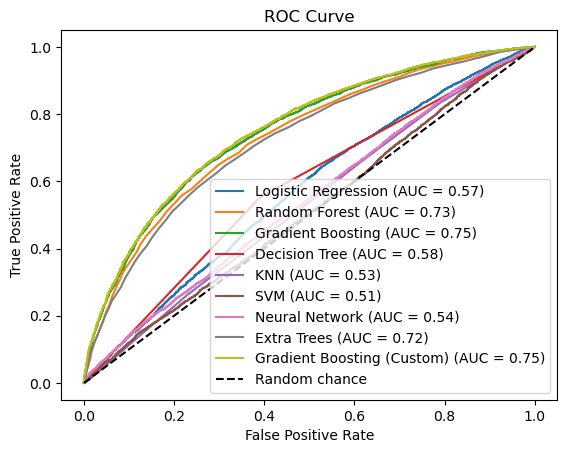

In [7]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Function to calculate confusion matrix for a given classifier
def evaluate_classifier(clf, X_train, y_train, X_val, y_val, model_name, ax):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_val)
    cm = confusion_matrix(y_val, predictions)
    auc_score = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
    print(f"{model_name} - AUC-ROC: {auc_score}")
    print(f"{model_name} - Confusion Matrix:\n {cm}\n")
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_val, clf.predict_proba(X_val)[:, 1])
    
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

# Set up plot
fig, ax = plt.subplots()

# Evaluating each classifier
evaluate_classifier(logistic_clf, X_train, y_train, X_val, y_val, "Logistic Regression", ax)
evaluate_classifier(random_forest_clf, X_train, y_train, X_val, y_val, "Random Forest", ax)
evaluate_classifier(gradient_boosting_clf, X_train, y_train, X_val, y_val, "Gradient Boosting", ax)
evaluate_classifier(decision_tree_clf, X_train, y_train, X_val, y_val, "Decision Tree", ax)
evaluate_classifier(knn_clf, X_train, y_train, X_val, y_val, "KNN", ax)
evaluate_classifier(svm_clf, X_train, y_train, X_val, y_val, "SVM", ax)
evaluate_classifier(neural_net_clf, X_train, y_train, X_val, y_val, "Neural Network", ax)
evaluate_classifier(extra_trees_clf, X_train, y_train, X_val, y_val, "Extra Trees", ax)

# You can also evaluate the Gradient Boosting model you've declared at the end
evaluate_classifier(gb_model, X_train, y_train, X_val, y_val, "Gradient Boosting (Custom)", ax)

# Finalize plot
ax.plot([0, 1], [0, 1], 'k--', label="Random chance")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc='best')
plt.show()


Logistic Regression - AUC-ROC: 0.5699068881061924
Logistic Regression - Confusion Matrix:
 [[4494 2204]
 [3572 2466]]

Random Forest - AUC-ROC: 0.7342130773044727
Random Forest - Confusion Matrix:
 [[4952 1746]
 [2434 3604]]

Gradient Boosting - AUC-ROC: 0.7502662914906101
Gradient Boosting - Confusion Matrix:
 [[4952 1746]
 [2193 3845]]

Decision Tree - AUC-ROC: 0.580901750840279
Decision Tree - Confusion Matrix:
 [[4080 2618]
 [2701 3337]]

KNN - AUC-ROC: 0.5301687649366296
KNN - Confusion Matrix:
 [[3926 2772]
 [3328 2710]]

SVM - AUC-ROC: 0.5127523198107022
SVM - Confusion Matrix:
 [[6698    0]
 [6038    0]]

Neural Network - AUC-ROC: 0.542384174637567
Neural Network - Confusion Matrix:
 [[6698    0]
 [6038    0]]

Extra Trees - AUC-ROC: 0.7219702583350139
Extra Trees - Confusion Matrix:
 [[4872 1826]
 [2396 3642]]

Gradient Boosting (Custom) - AUC-ROC: 0.7548903475955161
Gradient Boosting (Custom) - Confusion Matrix:
 [[4922 1776]
 [2155 3883]]



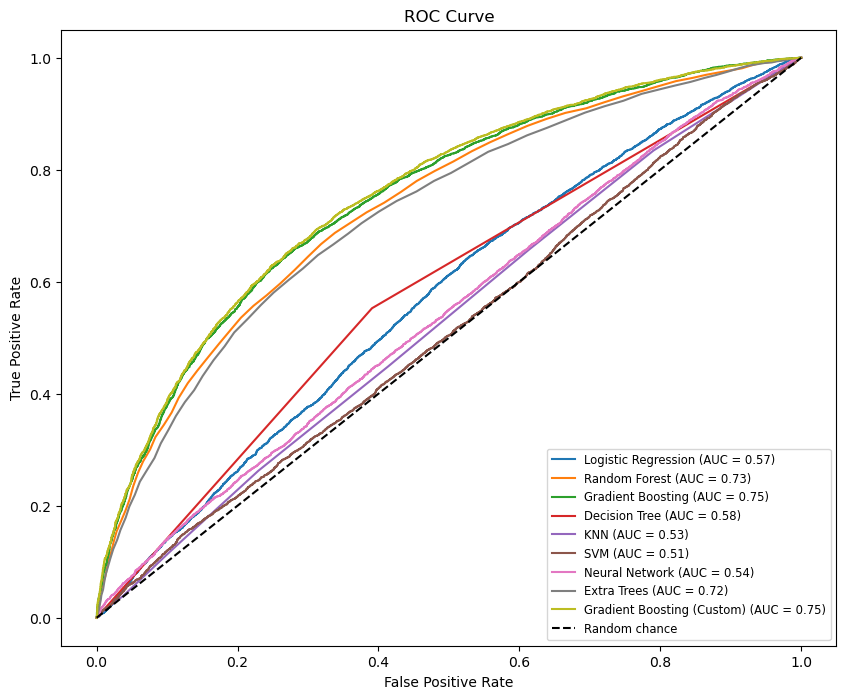

In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Function to calculate confusion matrix for a given classifier
def evaluate_classifier(clf, X_train, y_train, X_val, y_val, model_name, ax):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_val)
    cm = confusion_matrix(y_val, predictions)
    auc_score = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
    print(f"{model_name} - AUC-ROC: {auc_score}")
    print(f"{model_name} - Confusion Matrix:\n {cm}\n")
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_val, clf.predict_proba(X_val)[:, 1])
    
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

# Set up plot with increased size
fig, ax = plt.subplots(figsize=(10, 8))

# Evaluating each classifier
evaluate_classifier(logistic_clf, X_train, y_train, X_val, y_val, "Logistic Regression", ax)
evaluate_classifier(random_forest_clf, X_train, y_train, X_val, y_val, "Random Forest", ax)
evaluate_classifier(gradient_boosting_clf, X_train, y_train, X_val, y_val, "Gradient Boosting", ax)
evaluate_classifier(decision_tree_clf, X_train, y_train, X_val, y_val, "Decision Tree", ax)
evaluate_classifier(knn_clf, X_train, y_train, X_val, y_val, "KNN", ax)
evaluate_classifier(svm_clf, X_train, y_train, X_val, y_val, "SVM", ax)
evaluate_classifier(neural_net_clf, X_train, y_train, X_val, y_val, "Neural Network", ax)
evaluate_classifier(extra_trees_clf, X_train, y_train, X_val, y_val, "Extra Trees", ax)

# You can also evaluate the Gradient Boosting model you've declared at the end
evaluate_classifier(gb_model, X_train, y_train, X_val, y_val, "Gradient Boosting (Custom)", ax)

# Finalize plot
ax.plot([0, 1], [0, 1], 'k--', label="Random chance")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc='best', fontsize='small')  # Reduce font size of legend
plt.show()


# ROC_AUC, precision and accuracy performance

In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, accuracy_score

# Function to calculate confusion matrix, AUC-ROC, precision, and accuracy for a given classifier
def evaluate_classifier(clf, X_train, y_train, X_val, y_val, model_name):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_val)
    probabilities = clf.predict_proba(X_val)[:, 1]

    cm = confusion_matrix(y_val, predictions)
    auc_score = roc_auc_score(y_val, probabilities)
    precision = precision_score(y_val, predictions)
    accuracy = accuracy_score(y_val, predictions)

    print(f"{model_name} - AUC-ROC: {auc_score}")
    print(f"{model_name} - Precision: {precision}")
    print(f"{model_name} - Accuracy: {accuracy}")
    print(f"{model_name} - Confusion Matrix:\n {cm}\n")

# Evaluating each classifier
evaluate_classifier(logistic_clf, X_train, y_train, X_val, y_val, "Logistic Regression")
evaluate_classifier(random_forest_clf, X_train, y_train, X_val, y_val, "Random Forest")
evaluate_classifier(gradient_boosting_clf, X_train, y_train, X_val, y_val, "Gradient Boosting")
evaluate_classifier(decision_tree_clf, X_train, y_train, X_val, y_val, "Decision Tree")
evaluate_classifier(knn_clf, X_train, y_train, X_val, y_val, "KNN")
evaluate_classifier(svm_clf, X_train, y_train, X_val, y_val, "SVM")
evaluate_classifier(neural_net_clf, X_train, y_train, X_val, y_val, "Neural Network")
evaluate_classifier(extra_trees_clf, X_train, y_train, X_val, y_val, "Extra Trees")

# Evaluating the Gradient Boosting model you've declared at the end
evaluate_classifier(gb_model, X_train, y_train, X_val, y_val, "Gradient Boosting (Custom)")


Logistic Regression - AUC-ROC: 0.5699068881061924
Logistic Regression - Precision: 0.528051391862955
Logistic Regression - Accuracy: 0.5464824120603015
Logistic Regression - Confusion Matrix:
 [[4494 2204]
 [3572 2466]]

Random Forest - AUC-ROC: 0.7347115377863163
Random Forest - Precision: 0.6794776119402985
Random Forest - Accuracy: 0.6769786432160804
Random Forest - Confusion Matrix:
 [[4980 1718]
 [2396 3642]]

Gradient Boosting - AUC-ROC: 0.750234147107139
Gradient Boosting - Precision: 0.6876006441223832
Gradient Boosting - Accuracy: 0.6905621859296482
Gradient Boosting - Confusion Matrix:
 [[4952 1746]
 [2195 3843]]

Decision Tree - AUC-ROC: 0.580901750840279
Decision Tree - Precision: 0.5603694374475231
Decision Tree - Accuracy: 0.5823649497487438
Decision Tree - Confusion Matrix:
 [[4080 2618]
 [2701 3337]]

KNN - AUC-ROC: 0.5301687649366296
KNN - Precision: 0.4943451295147756
KNN - Accuracy: 0.5210427135678392
KNN - Confusion Matrix:
 [[3926 2772]
 [3328 2710]]



/Users/gimmihwa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM - AUC-ROC: 0.5127523198107022
SVM - Precision: 0.0
SVM - Accuracy: 0.5259108040201005
SVM - Confusion Matrix:
 [[6698    0]
 [6038    0]]



/Users/gimmihwa/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Network - AUC-ROC: 0.542384174637567
Neural Network - Precision: 0.0
Neural Network - Accuracy: 0.5259108040201005
Neural Network - Confusion Matrix:
 [[6698    0]
 [6038    0]]

Extra Trees - AUC-ROC: 0.7219702583350139
Extra Trees - Precision: 0.6660570592538405
Extra Trees - Accuracy: 0.668498743718593
Extra Trees - Confusion Matrix:
 [[4872 1826]
 [2396 3642]]

Gradient Boosting (Custom) - AUC-ROC: 0.7548903475955161
Gradient Boosting (Custom) - Precision: 0.6861636331507334
Gradient Boosting (Custom) - Accuracy: 0.6913473618090452
Gradient Boosting (Custom) - Confusion Matrix:
 [[4922 1776]
 [2155 3883]]



In [248]:
# learning_rate=0.1, max_depth=3, min_samples_split=12, n_estimators=500, random_state=777
from sklearn.metrics import roc_auc_score

# 확률 예측
probabilities = gb_model.predict_proba(X_val)[:, 1]  # 1 클래스에 속할 확률만 선택

# AUC-ROC 계산
auc_roc = roc_auc_score(y_val, probabilities)
print('AUC-ROC:', auc_roc)


AUC-ROC: 0.7548330811400397


In [250]:
# learning_rate=0.05, max_depth=3, min_samples_split=12, n_estimators=500, random_state=777
from sklearn.metrics import roc_auc_score

# 확률 예측
probabilities = gb_model.predict_proba(X_val)[:, 1]  # 1 클래스에 속할 확률만 선택

# AUC-ROC 계산
auc_roc = roc_auc_score(y_val, probabilities)
print('AUC-ROC:', auc_roc)


AUC-ROC: 0.7548903475955161


In [251]:
from sklearn.metrics import accuracy_score


predictions = gb_model.predict(X_val)
gb_accuracy = accuracy_score(y_val,predictions)
print('GBM 정확도:{0:4f}'.format(gb_accuracy))

predictions[:10]  # Displaying the first 10 predictions

GBM 정확도:0.691347


array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])

AUC-ROC와 Accuracy는 모델의 성능을 측정하는 데 사용되는 두 가지 다른 지표입니다. 각각의 지표는 다른 측면의 정보를 제공하므로 비교하기 어렵습니다. 그러나 그들의 의미와 강점을 이해하면 어떤 지표가 주어진 상황에서 더 유용한지 결정할 수 있습니다.

AUC-ROC (0.7548):
AUC-ROC는 이진 분류 모델의 성능을 평가하는 데 사용되는 지표입니다.
AUC-ROC 값은 0.5 (완전한 랜덤 분류기)에서 1 (완벽한 분류기) 사이의 값을 가집니다.
AUC-ROC는 여러 임계값에서 모델의 True Positive Rate와 False Positive Rate 사이의 관계를 평가합니다.
AUC-ROC 값이 0.75는 모델이 꽤 좋은 성능을 보이고 있음을 나타냅니다.
Accuracy (0.6913):
Accuracy는 올바르게 분류된 인스턴스의 비율을 나타냅니다.
불균형한 데이터 세트에서는 Accuracy만으로 모델의 성능을 평가하는 것은 오해의 소지가 있습니다. 그러나 여러분의 데이터는 상대적으로 균형을 이루고 있으므로 Accuracy도 유용한 지표가 될 수 있습니다.
69.13%의 Accuracy는 모델이 약 69%의 인스턴스를 올바르게 분류했다는 것을 의미합니다.
둘 중 어느 것이 "더 정확한" 지표인지 결정하기는 어렵습니다. 그러나 AUC-ROC는 다양한 분류 임계값에서 모델의 성능을 종합적으로 평가하는 데 더 우수한 지표로 간주됩니다. 따라서 주어진 문제에 대한 모델의 전반적인 성능을 평가하려면 AUC-ROC 값을 기준으로 하면 좋습니다.

In [211]:
test

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMPLOYED_x_BIRTH_0
0,280139,2.0,0.000935,0.137485,0.129471,0.113924,0.031329,0,0.767838,4,...,0,0,0,0,0,0,0,0,0,1
1,284067,1.0,0.001012,0.101690,0.089060,0.113924,0.035792,0,0.848788,3,...,0,0,0,0,0,0,0,0,0,1
2,213484,0.0,0.001704,0.119588,0.148494,0.113924,0.032561,0,0.534368,4,...,0,0,0,0,0,0,0,0,0,1
3,430855,0.0,0.000935,0.293772,0.149666,0.329114,0.015221,0,0.980286,4,...,0,0,0,0,0,0,0,0,0,1
4,342521,1.0,0.001512,0.077972,0.061110,0.063291,0.020713,0,0.995987,4,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4711,378832,0.0,0.000473,0.250475,0.240099,0.240506,0.018029,0,0.832083,3,...,0,0,0,0,0,0,0,0,0,1
4712,302837,0.0,0.001127,0.028247,0.025587,0.031646,0.025164,0,0.871424,2,...,0,0,0,0,0,0,0,0,0,1
4713,313840,0.0,0.002666,0.045196,0.063998,0.050633,0.046220,0,0.613355,3,...,0,0,0,0,0,0,0,1,0,1
4714,368211,0.0,0.001012,0.116378,0.181614,0.113924,0.019101,0,0.716504,1,...,0,0,0,0,0,0,0,0,1,1


In [214]:
import numpy as np # 각 모델에서 내부적으로 관련 라이브러리 사용 가능

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier             # 1. K-Nearest Neighbor(KNN)
from sklearn.linear_model import LogisticRegression            # 2. Logistic Regression
from sklearn.svm import SVC                                                # 3. SVC
from sklearn.tree import DecisionTreeClassifier                   # 4. Decision Tree
from sklearn.ensemble import RandomForestClassifier       # 5. Random Forest
from sklearn.ensemble import ExtraTreesClassifier             # 6. Extra Tree
from sklearn.ensemble import GradientBoostingClassifier  # 7. GBM
from sklearn.naive_bayes import GaussianNB                     # 8. GaussianNB
from xgboost import XGBClassifier                                     # 9. XGBoost
from lightgbm import LGBMClassifier                                 # 10. LightGBM
import warnings

warnings.filterwarnings('ignore')

In [215]:
logreg_model = LogisticRegression(C=18.288277344191805, penalty='l2', random_state=1)

xgb_model = XGBClassifier(
    eval_metric = 'logloss',
    learning_rate=0.17, 
    n_estimators=10, 
    max_depth=6, 
    min_child_weight=1,
    gamma=0.2,
    reg_alpha=0.01,
    colsample_bytree=0.85,
    subsample=0.9,
    random_state=1
)

random_model = RandomForestClassifier(
    max_depth=None, 
    max_features=0.8, 
    min_samples_leaf=2, 
    min_samples_split=6, 
    n_estimators=200, 
    random_state=1
)

extra_model = ExtraTreesClassifier(
    max_depth=None, 
    max_features=0.5, 
    min_samples_leaf=2, 
    min_samples_split=10, 
    n_estimators=50, 
    random_state=1
)

In [227]:
from sklearn.ensemble import VotingClassifier

grid_hard = VotingClassifier(estimators = [
        ('Gradient Boosting',gb_model),
        ('Logistic Regression', logreg_model),
        ('XGBoost', xgb_model),
        ('Random Forest', random_model), 
        ('Extra Trees', extra_model),
    ], voting = 'hard')

score = cross_val_score(grid_hard, X_train, y_train, cv=5, scoring='accuracy')
print(np.mean(score)*100)

67.495635975595


In [226]:
print(X_train.shape)
print(y_train.shape)


(29716, 174)
(29716,)


In [253]:
submission = pd.DataFrame(columns=['SK_ID_CURR', 'TARGET'])
submission['SK_ID_CURR'] = test['SK_ID_CURR']

In [254]:
submission

,SK_ID_CURR,TARGET
0,280139,NaN
1,284067,NaN
2,213484,NaN
3,430855,NaN
4,342521,NaN
...,...,...
4711,378832,NaN
4712,302837,NaN
4713,313840,NaN
4714,368211,NaN


In [255]:
submission["TARGET"] = gb_model.predict(test)
submission = submission.astype('int')
submission.head()

,SK_ID_CURR,TARGET
0,280139,1
1,284067,1
2,213484,0
3,430855,1
4,342521,0


In [252]:
submission["TARGET"] = gb_model.predict(test)
submission = submission.astype('int')
submission.head()

,SK_ID_CURR,TARGET
0,280139,1
1,284067,1
2,213484,0
3,430855,1
4,342521,0


In [256]:
submission

,SK_ID_CURR,TARGET
0,280139,1
1,284067,1
2,213484,0
3,430855,1
4,342521,0
...,...,...
4711,378832,0
4712,302837,1
4713,313840,1
4714,368211,0


In [257]:
submission.to_csv('ass3_predict.csv', header = True, index = False)

In [53]:
import pickle
with open('ass3_final_train_sample.pickle', 'wb') as pickle_filename:
    pickle.dump(train, pickle_filename)
# with open('ass3_final_X_test.pickle', 'wb') as pickle_filename:
#     pickle.dump(X_test, pickle_filename)
# with open('ass3_final_train_y.pickle', 'wb') as pickle_filename:
#     pickle.dump(y_train, pickle_filename)